<a href="https://colab.research.google.com/github/SohailVibeCoder/Olist-ML-project/blob/main/P%26BD_assignment-%20Final%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup

In [2]:
!pip install xgboost
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score


# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
print(os.getcwd())
os.chdir("/content/drive/MyDrive/")

customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
prod_cat_name_translation_df = pd.read_csv("product_category_name_translation.csv")


print(customers_df.shape)
print(geolocation_df.shape)
print(order_items_df.shape)
print(order_payments_df.shape)
print(order_reviews_df.shape)
print(orders_df.shape)
print(products_df.shape)
print(sellers_df.shape)
print(prod_cat_name_translation_df.shape)




/content
(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


Data loading and merging into dataframe for cleaning

In [4]:

# Load all required datasets
orders_df = pd.read_csv("olist_orders_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
customers_df = pd.read_csv("olist_customers_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
translation_df = pd.read_csv("product_category_name_translation.csv")

# Perform the sequential left merges
# Left merge ensures we keep all orders from the base orders_df
# No geolocation - adds to much
full_df= (
    orders_df
    .merge(order_reviews_df, on='order_id', how='left')
    .merge(order_payments_df, on='order_id', how='left')
    .merge(customers_df, on='customer_id', how='left')
    # Merge order items (creates multiple rows per order)
    .merge(order_items_df, on='order_id', how='left')
    # Merge product details
    .merge(products_df, on='product_id', how='left')
    # Merge seller details
    .merge(sellers_df, on='seller_id', how='left')
    # Merge product category translation
    .merge(translation_df, on='product_category_name', how='left')
)

print(f"Initial row count: {len(orders_df)}")
print(f"Merged raw DataFrame row count: {len(full_df)}")
print("\nMerged Raw DataFrame Head (Note: Multiple rows per order are expected):")
print(full_df.head())
print("\nMerged Raw DataFrame Info:")
full_df.info()

full_df.isnull().sum()

Initial row count: 99441
Merged raw DataFrame row count: 119143

Merged Raw DataFrame Head (Note: Multiple rows per order are expected):
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_de

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,177
order_delivered_carrier_date,2086
order_delivered_customer_date,3421
order_estimated_delivery_date,0
review_id,997
review_score,997


Data cleaning

In [5]:
full_df = full_df[full_df['order_status'] == 'delivered'].copy()
# Only using order status as delivered as undelivered items are not relevant information for cust reviews



# 2. Convert Date/Time Columns to the correct format (datetime)
# The dates are currently stored as 'object' (text/string), which prevents time-based math.

date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
]

for col in date_columns:
    # pd.to_datetime() is the standard way to convert a text column into a datetime object.
    # The 'errors=' argument tells pandas what to do if it finds a date it can't parse:
    # 'coerce' will turn bad/missing dates into NaT (Not a Time), which we can handle later.
    full_df[col] = pd.to_datetime(full_df[col], errors='coerce')

print("\nDate columns successfully converted to datetime format.")

# ---

# 3. Drop remaining non-essential missing values (The 'hard' nulls)

# We are dropping rows that are missing core product/payment details.
# These records cannot contribute to sales or product analysis.
full_df.dropna(subset=[
    'price',
    'product_id',
    'review_score',
    'product_category_name_english' # Essential for sales category analysis
], inplace=True)

print(f"Rows after dropping core nulls: {len(full_df)}")

# ---

# 4. Handle text fields (The 'soft' nulls)

# It's normal for customers to leave a review score without a comment.
# Filling the NaNs with an empty string ('') prevents errors if you run text analysis later.
full_df['review_comment_title'].fillna('', inplace=True)
full_df['review_comment_message'].fillna('', inplace=True)

print("\nText comment nulls filled with empty strings.")

print("\n✅ Data cleaning and filtering complete!")
print("Check the new DataFrame info to confirm data types:")
full_df.info()


Date columns successfully converted to datetime format.
Rows after dropping core nulls: 113213

Text comment nulls filled with empty strings.

✅ Data cleaning and filtering complete!
Check the new DataFrame info to confirm data types:


/tmp/ipython-input-278931964.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['review_comment_title'].fillna('', inplace=True)
/tmp/ipython-input-278931964.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

<class 'pandas.core.frame.DataFrame'>
Index: 113213 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113213 non-null  object        
 1   customer_id                    113213 non-null  object        
 2   order_status                   113213 non-null  object        
 3   order_purchase_timestamp       113213 non-null  datetime64[ns]
 4   order_approved_at              113199 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113211 non-null  datetime64[ns]
 6   order_delivered_customer_date  113205 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113213 non-null  datetime64[ns]
 8   review_id                      113213 non-null  object        
 9   review_score                   113213 non-null  float64       
 10  review_comment_title           113213 non-null  object        
 11  revie

Product performance insights - useful for EDA

In [6]:
# 🧹 STEP 0: Remove missing product categories or review scores
# We only keep rows where both category and review exist
df = full_df.dropna(subset=['product_category_name_english', 'review_score'])


# ⚙️ STEP 1: Define the aggregation rules
# This tells Pandas what summary statistics to calculate for each group (category)
agg_rules = {
    'price': ['sum', 'mean', 'count'],   # total sales value, average item price, number of items sold
    'order_id': 'nunique',               # count of *unique* orders containing that category
    'review_score': 'mean'               # average review score for that category
}


# 📊 STEP 2: Group the data and apply the aggregation rules
# We group by each unique product category, then calculate all of the above stats
product_perf = (
    df.groupby('product_category_name_english')  # group rows by product category
      .agg(agg_rules)                             # apply our aggregation dictionary
      .reset_index()                              # turn the index back into a normal column
)


# 🏷️ STEP 3: Rename and flatten the resulting column names
# After aggregation, Pandas creates multi-level column names like ('price', 'sum')
# We flatten them into readable column names and rename them for clarity
product_perf.columns = [
    'product_category',     # the category name
    'total_sales_value',    # sum of all item prices in that category
    'avg_item_price',       # average item price in that category
    'items_count',          # total number of items sold (rows)
    'distinct_orders',      # number of unique orders containing that category
    'avg_review_score'      # average customer rating for that category
]


# 4)  positive-review rate (>=4)
# Create a binary label and aggregate its mean
df['is_positive'] = (df['review_score'] >= 4).astype(int)

pos_rate = (
    df.groupby('product_category_name_english')['is_positive']
      .mean()
      .reset_index(name='positive_rate')
)

# 💡 FIX: Rename the category column in pos_rate to match product_perf
pos_rate.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)


# 🔗 STEP 5: Merge the positive rate back into the main summary table
product_perf = product_perf.merge(pos_rate, on='product_category', how='left')


# 🔽 STEP 6: Sort the final summary table by total sales value (optional)
# This makes it easier to read and analyze top-performing categories
product_perf = product_perf.sort_values('total_sales_value', ascending=False)

product_perf.to_csv("product_performance_summary.csv")

Feature Engineering

In [7]:

# --- 1. Load the Cleaned Data ---
# It's crucial to load the date columns correctly from the CSV.
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp'
]
# Replace "full_df_cleaned (3).csv" with the actual full path you copied
full_df = pd.read_csv(
    "/content/drive/MyDrive/full_df_cleaned.csv",
    parse_dates=date_columns
)

print("Cleaned data loaded successfully.")


# --- 2. Define the Snapshot Date ---
# The snapshot date is the day AFTER the last order in the dataset.
snapshot_date = full_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
print(f"Snapshot Date for Recency calculation: {snapshot_date}")


# --- 3. Perform RFM Aggregation ---
# Group by unique customer ID and calculate R, F, M
rfm_df = full_df.groupby('customer_unique_id').agg(
    # R (Recency): Difference between snapshot date and last purchase date (in days)
    Recency=('order_purchase_timestamp',
             lambda x: (snapshot_date - x.max()).days),

    # F (Frequency): Count of unique orders
    Frequency=('order_id', 'nunique'),

    # M (Monetary): Sum of total payment value
    Monetary=('payment_value', 'sum')
).reset_index()

print("\n--- RFM Aggregation Complete ---")
print(rfm_df.head())


# --- 4. Save the RFM summary table ---
# This table is ready to be merged back into the full transaction data later.
rfm_df.to_csv("customer_rfm_summary.csv", index=False)
print("\nRFM summary table saved as customer_rfm_summary.csv")

Cleaned data loaded successfully.
Snapshot Date for Recency calculation: 2018-08-30 15:00:37

--- RFM Aggregation Complete ---
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89

RFM summary table saved as customer_rfm_summary.csv


In [8]:
# --- 1. Create RFM (Recency, Frequency, Monetary) Features ---
snapshot_date = full_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
rfm_df = full_df.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    Frequency=('order_id', 'nunique'),
    Monetary=('payment_value', 'sum')
).reset_index()

rfm_df.to_csv("customer_rfm_summary.csv", index=False)

# Merge RFM metrics back into the main dataset
full_df = full_df.merge(rfm_df, on='customer_unique_id', how='left')

# --- 2. Delivery Time Features ---
# Calculate total delivery duration and deviation from estimated delivery date
full_df['delivery_time_delta'] = full_df['order_delivered_customer_date'] - full_df['order_purchase_timestamp']
full_df['actual_delivery_days'] = full_df['delivery_time_delta'].dt.days.fillna(
    full_df['delivery_time_delta'].dt.days.median()
)
full_df['delivery_performance_days'] = (
    full_df['order_estimated_delivery_date'] - full_df['order_delivered_customer_date']
).dt.days.fillna(0)

# --- 3. Product Volume Feature ---
# Combine product dimensions into a single volume variable
full_df['product_volume_cm3'] = (
    full_df['product_length_cm'] * full_df['product_height_cm'] * full_df['product_width_cm']
)
volume_median = full_df['product_volume_cm3'].median()
full_df['product_volume_cm3'].fillna(volume_median, inplace=True)

# --- 4. One-Hot Encoding of Categorical Variables ---
categorical_cols = ['product_category_name_english', 'customer_state', 'payment_type', 'seller_state']
full_df_encoded = pd.get_dummies(full_df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

# --- 5. Drop Irrelevant or Redundant Columns ---
columns_to_drop = [
    'order_id', 'customer_id', 'review_id', 'product_id', 'seller_id', 'customer_unique_id',
    'order_status', 'review_comment_title', 'review_comment_message',
    'customer_city', 'seller_city', 'product_category_name',
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date',
    'review_answer_timestamp', 'shipping_limit_date',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'customer_zip_code_prefix', 'seller_zip_code_prefix', 'delivery_time_delta'
]

final_ml_df = full_df_encoded.drop(columns=columns_to_drop, errors='ignore')
final_ml_df.to_csv("ml_ready_feature_table_FINAL.csv", index=False)

print(f"Feature engineering complete. Final dataset shape: {final_ml_df.shape}")

/tmp/ipython-input-2417211349.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['product_volume_cm3'].fillna(volume_median, inplace=True)


Feature engineering complete. Final dataset shape: (113213, 137)


XGBoost Classifier

Training XGBoost Model (scale_pos_weight=3.31)...
Model training complete.
Optimal threshold selected: 0.100 (F1 for bad class = 0.509)

--- FINAL MODEL PERFORMANCE (Optimized Threshold) ---
              precision    recall  f1-score   support

     0 (Bad)       0.49      0.53      0.51      5248
    1 (Good)       0.85      0.84      0.84     17395

    accuracy                           0.76     22643
   macro avg       0.67      0.68      0.68     22643
weighted avg       0.77      0.76      0.77     22643


--- TOP 10 MOST IMPORTANT FEATURES ---
delivery_performance_days                          0.105848
Monetary                                           0.025803
customer_state_MT                                  0.023380
price                                              0.022833
Frequency                                          0.020090
product_category_name_english_furniture_bedroom    0.019668
actual_delivery_days                               0.019406
product_category_name_

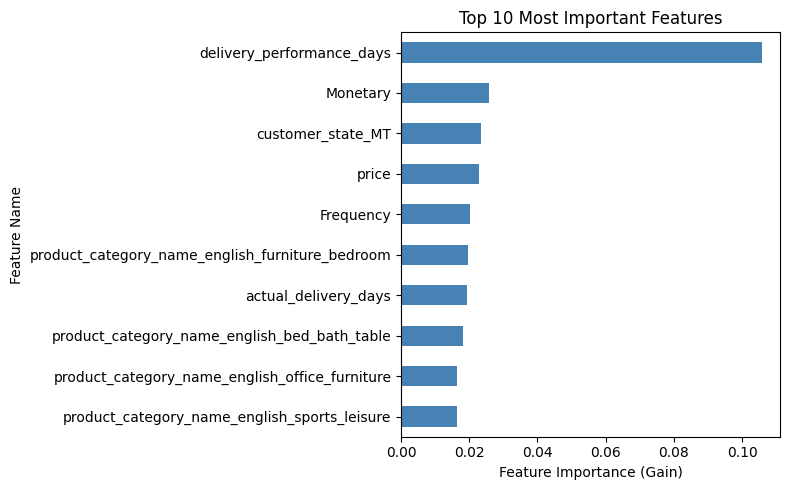

In [14]:
# --- 1. Load Prepared Dataset ---
df_ml = pd.read_csv("ml_ready_feature_table_FINAL.csv")

# Target variable: 1 = Good (≥4), 0 = Bad (<4)
y_class = (df_ml['review_score'] >= 4).astype(int)
X = df_ml.drop(columns=['review_score', 'order_item_id'])

# --- 2. Train-Test Split and Class Weighting ---
from sklearn.model_selection import train_test_split # Import train_test_split

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Calculate imbalance ratio for scale_pos_weight
count_class_1 = y_train_class.value_counts()[1]
count_class_0 = y_train_class.value_counts()[0]
scale_pos_weight = count_class_1 / count_class_0

# --- 3. Train XGBoost Classifier ---
from xgboost import XGBClassifier # Import XGBClassifier
xgb_final_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

print(f"Training XGBoost Model (scale_pos_weight={scale_pos_weight:.2f})...")
xgb_final_model.fit(X_train, y_train_class)
print("Model training complete.")

# --- 4. Threshold Optimization (for bad-review class) ---
# The default 0.5 cutoff may not perform well for imbalanced data.
# This loop searches for a lower threshold that maximizes F1 for the minority (bad) class.
y_proba = xgb_final_model.predict_proba(X_test)
y_proba_minority = y_proba[:, 0]  # Probability of being class 0 (bad review)

thresholds = np.linspace(0.50, 0.10, 20)
best_f1, best_threshold = 0, 0
from sklearn.metrics import f1_score # Import f1_score
for threshold in thresholds:
    y_pred_temp = np.where(y_proba_minority > threshold, 0, 1)
    f1 = f1_score(y_test_class, y_pred_temp, pos_label=0)
    if f1 > best_f1:
        best_f1, best_threshold = f1, threshold

print(f"Optimal threshold selected: {best_threshold:.3f} (F1 for bad class = {best_f1:.3f})")

# --- 5. Final Evaluation ---
y_pred_final = np.where(y_proba_minority > best_threshold, 0, 1)
from sklearn.metrics import classification_report # Import classification_report
print("\n--- FINAL MODEL PERFORMANCE (Optimized Threshold) ---")
print(classification_report(y_test_class, y_pred_final, target_names=['0 (Bad)', '1 (Good)']))

# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

# Extract and rank features by importance
importances = pd.Series(xgb_final_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

print("\n--- TOP 10 MOST IMPORTANT FEATURES ---")
print(top_features)

# Visualize top 10 features
plt.figure(figsize=(8, 5))
top_features.sort_values().plot(kind='barh', color='steelblue')
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

In [10]:


# --- 1. Preparation (Requires X_train, y_train_class, and xgb_final_model from the previous successful run) ---

# We use the final, optimized model that was previously trained.
# Predict the probability on the TRAINING data
y_proba_train = xgb_final_model.predict_proba(X_train)
y_proba_minority_train = y_proba_train[:, 0]

# Use the best threshold found in the last step (0.100)
# We must use the SAME threshold (0.100) for both Training and Testing sets.
BEST_THRESHOLD = 0.100

# --- 2. Evaluate Performance on the TRAINING Set ---

# Apply the best threshold to the training probabilities
y_pred_train_final = np.where(y_proba_minority_train > BEST_THRESHOLD, 0, 1)


print("--- TRAINING SET Performance Check ---")
print(classification_report(y_train_class, y_pred_train_final, target_names=['0 (Bad)', '1 (Good)']))

--- TRAINING SET Performance Check ---
              precision    recall  f1-score   support

     0 (Bad)       0.52      0.56      0.54     20990
    1 (Good)       0.87      0.85      0.86     69580

    accuracy                           0.78     90570
   macro avg       0.70      0.71      0.70     90570
weighted avg       0.79      0.78      0.78     90570



In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score


# --- 1. Load Data, Define Target (y_class), and Features (X) ---

# Load the final ML-ready dataset
df_ml = pd.read_csv("ml_ready_feature_table_FINAL.csv")

# Define the Target (y): 1=Good Review (>=4), 0=Bad Review (<4)
y_class = (df_ml['review_score'] >= 4).astype(int)

# Define Features (X): Drop the target and the noisy 'order_item_id'
X = df_ml.drop(columns=['review_score', 'order_item_id'])


# --- 2. Split Data and Prepare Evaluation Set ---

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

# Prepare the evaluation set for plotting the loss curve
eval_set = [(X_train, y_train_class), (X_test, y_test_class)]

# Calculate the weight ratio (used later for training)
count_class_1 = y_train_class.value_counts()[1]
count_class_0 = y_train_class.value_counts()[0]
scale_pos_weight = count_class_1 / count_class_0


# --- 3. Train the XGBoost Model and Record History ---

xgb_final_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

print(f"Starting Training to Record Loss History (eval_metric: logloss)...")

# Pass the evaluation set to the fit function and store the results in 'evals_result'
xgb_final_model.fit(
    X_train,
    y_train_class,
    eval_set=eval_set,
    eval_metric="logloss", # We use 'logloss' as the measure of model error
    verbose=False,        # Suppress output for clean plot generation
    callbacks=[
        # Callback to store the history
        xgb_final_model.get_callbacks()[0]
        ]
)
print("Training complete and loss history recorded.")


# --- 4. Plot the Loss Curve ---

# Retrieve the recorded loss data from the model's history
results = xgb_final_model.evals_result()
epochs = len(results['validation_0']['logloss'])

# Plotting the Training Loss (validation_0) and Testing Loss (validation_1)
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results['validation_0']['logloss'], label='Training Loss')
plt.plot(range(epochs), results['validation_1']['logloss'], label='Testing Loss')

plt.title('XGBoost Loss Curve: Training vs. Testing Error', fontsize=16)
plt.ylabel('Log Loss', fontsize=14)
plt.xlabel('Boosting Rounds (Epochs)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.savefig('xgb_loss_curve.png')
plt.close()
print("Loss Curve plot saved as xgb_loss_curve.png")

Starting Training to Record Loss History (eval_metric: logloss)...


AttributeError: 'XGBClassifier' object has no attribute 'get_callbacks'